In [7]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

from xgboost import plot_importance
import matplotlib.pyplot as plt

from utils.query_snowflake import SnowflakeConnector

import mlflow

In [8]:
person_df = pd.read_csv( r"C:\Users\User\Downloads\pums\psam_p05.csv")
housing_df = pd.read_csv( r"C:\Users\User\Downloads\pums\psam_h05.csv")

In [9]:
person_df

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2021GQ0000060,7,1,700,3,5,1029928,58,34,...,54,55,110,107,12,12,99,61,12,63
1,P,2021GQ0000334,7,1,1900,3,5,1029928,106,21,...,8,112,204,198,105,99,214,9,105,113
2,P,2021GQ0000904,7,1,1100,3,5,1029928,13,67,...,10,24,11,24,12,11,0,8,11,11
3,P,2021GQ0001018,7,1,900,3,5,1029928,19,20,...,0,0,0,0,28,16,18,0,31,39
4,P,2021GQ0001134,7,1,1800,3,5,1029928,68,65,...,14,73,137,16,16,65,63,124,69,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30045,P,2021HU1414420,7,1,200,3,5,1029928,61,71,...,66,20,17,21,55,56,63,65,64,18
30046,P,2021HU1414420,7,2,200,3,5,1029928,78,62,...,75,26,21,22,82,76,83,73,71,26
30047,P,2021HU1414687,7,1,900,3,5,1029928,106,66,...,33,32,94,102,136,104,94,157,198,27
30048,P,2021HU1414728,7,1,700,3,5,1029928,65,50,...,63,21,55,19,20,90,82,125,51,78


In [3]:
housing_df = housing_df[[col for col in housing_df.columns if col not in ['RT', 'PUMA10', 'PUMA20', 'DIVISION', 'REGION', 'ST', 'ADJINC']]]

In [4]:
df = person_df.merge(housing_df, on="SERIALNO", how="left")

In [5]:
len(person_df.SERIALNO.unique()), len(person_df)

(13615, 30050)

In [71]:
df = df[~df['FS'].isna()]
df = df.reset_index(drop=True)
df["FS"] = df["FS"].map({1: 1, 2: 0})

In [72]:
missing_ratio = df.isna().mean()
high_missing_ratio = df.loc[:, missing_ratio >= 0.95].columns.tolist()

In [74]:
exclusions =  ['FS', 'RT', 'SERIALNO', 'NAICSP', 'SOCP', 'ADJINC', 'ADJHSG', 'WGTP', 'PWGTP'] + ['WGTP' + str(i) for i in range(81)] + ['PWGTP' + str(i) for i in range(81)]
features = [col for col in df.columns if col not in exclusions]

X = df[features]
X = X.astype({col: 'float64' for col in X.select_dtypes(include='int').columns})
y = df["FS"]
weight = df['PWGTP']


X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
    X, y, weight, test_size=0.1, random_state=42
)

# --------------------
# Train model
# --------------------
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_train, y_train, sample_weight=weight_train)

# --------------------
# Evaluate
# --------------------
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, sample_weight=weight_test))


2025/05/08 22:38:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ac499dfd92dd4bee86105a9a0dd63dd2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/05/08 22:38:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."


              precision    recall  f1-score   support

           0       0.95      0.99      0.97  264866.0
           1       0.89      0.64      0.74   38363.0

    accuracy                           0.94  303229.0
   macro avg       0.92      0.81      0.85  303229.0
weighted avg       0.94      0.94      0.94  303229.0



In [75]:
# 1. Define groups
income_fields = ["FINCP", "HINCP"] + ["INTP", "OIP", "PAP", "PERNP", "PINCP", "RETP", "SEMP", "SSIP", "SSP", "WAGP"]
housing_fields = ["ELEP", "CONP", "FULP", "GASP", "INSP", "MHP", "MRGP", "RNTP", "SMP", 
                  "WATP", "GRNTP", "SMOCP", "TAXAMT", "CONP",]

# 2. Adjust to 2022 dollars
for field in income_fields:
    df[field] = df[field] * df["ADJINC"] / 1_000_000

for field in housing_fields:
    df[field] = df[field] * df["ADJHSG"] / 1_000_000

In [76]:
allowed_codes = [
    '11','21','22','23','31','32','33','3M','42','44','45','48','49',
    '4M','51','52','53','54','55','56','61','62','71','72','81','92','99','na'
]

df['NAICSP_clean'] = df['NAICSP'].fillna('na').apply(
    lambda x: str(x)[:2] if str(x)[:2] in allowed_codes else 'na'
)

naicsp_dummies = pd.get_dummies(
    pd.Categorical(df['NAICSP_clean'], categories=allowed_codes),
    prefix='NAICSP'
)

# Step 3: Combine and drop original columns
df = pd.concat([df.drop(columns=['NAICSP', 'NAICSP_clean']), naicsp_dummies], axis=1)

In [77]:
allowed_socp_codes = [
    '11','13','15','17','19','21','23','25','27','29','31','33',
    '35','37','39','41','43','45','47','49','51','53','55','99','na'
]

# Step 1: Clean SOCP values to 2-digit prefix or 'na'
df['SOCP_clean'] = df['SOCP'].fillna('na').apply(
    lambda x: str(x)[:2] if str(x)[:2] in allowed_socp_codes else 'na'
)

# Step 2: One-hot encode with fixed categories
socp_dummies = pd.get_dummies(
    pd.Categorical(df['SOCP_clean'], categories=allowed_socp_codes),
    prefix='SOCP'
)

# Step 3: Drop original columns and combine
df = pd.concat([df.drop(columns=['SOCP', 'SOCP_clean']), socp_dummies], axis=1)


In [78]:
# Derived ratios
df["income_per_person"] = df["HINCP"] / (df["NP"].replace(0, np.nan))
df["income_per_room"] = df["HINCP"] / (df["RMSP"].replace(0, np.nan))
df["rent_to_income_ratio"] = df["RNTP"] / (df["HINCP"].replace(0, np.nan))

In [79]:
exclusions =  ['FS', 'RT', 'SERIALNO', 'NAICSP', 'SOCP', 'ADJINC', 'ADJHSG', 'WGTP', 'PWGTP'] + ['WGTP' + str(i) for i in range(81)] + ['PWGTP' + str(i) for i in range(81)]
features = [col for col in df.columns if col not in exclusions]

X = df[features]
X = X.astype({col: 'float64' for col in X.select_dtypes(include='int').columns})
y = df["FS"]
weight = df['PWGTP']


X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
    X, y, weight, test_size=0.1, random_state=42
)

# --------------------
# Train model
# --------------------
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_train, y_train, sample_weight=weight_train)

# --------------------
# Evaluate
# --------------------
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, sample_weight=weight_test))

2025/05/08 22:38:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dc84fa75c87449fc8af51eeed3cd69ad', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/05/08 22:38:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:38:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."


              precision    recall  f1-score   support

           0       0.95      0.99      0.97  264866.0
           1       0.90      0.67      0.77   38363.0

    accuracy                           0.95  303229.0
   macro avg       0.93      0.83      0.87  303229.0
weighted avg       0.95      0.95      0.95  303229.0



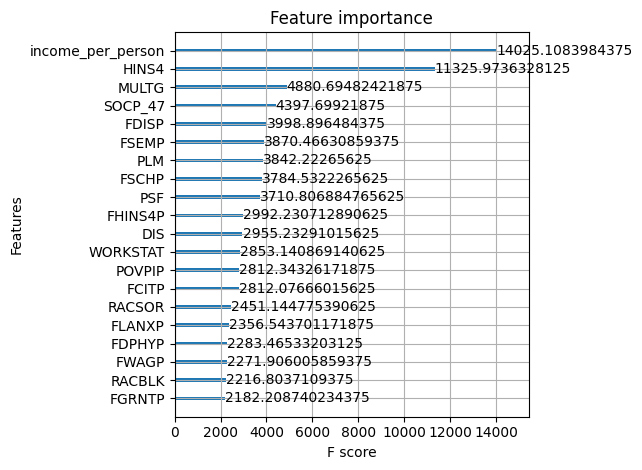

In [80]:
plot_importance(model, max_num_features=20, importance_type='gain')
plt.tight_layout()
plt.show()

In [87]:
import mlflow
import mlflow.xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_recall_curve
import numpy as np
import os

# Set experiment (creates if it doesn't exist)
mlflow.set_experiment("food_stamp_prediction")

# Turn on autologging for XGBoost
mlflow.xgboost.autolog()

# Start run
with mlflow.start_run(run_name="xgb_weighted_fs_model_v1") as run:
    run_id = run.info.run_id
    experiment = mlflow.get_experiment_by_name("food_stamp_prediction")
    
    # Exclude non-feature columns
    exclusions =  ['FS', 'RT', 'SERIALNO', 'NAICSP', 'SOCP', 'ADJINC', 'ADJHSG', 'WGTP', 'PWGTP'] + \
                  ['WGTP' + str(i) for i in range(81)] + ['PWGTP' + str(i) for i in range(81)]
    features = [col for col in df.columns if col not in exclusions]

    # Prepare data
    X = df[features]
    X = X.astype({col: 'float64' for col in X.select_dtypes(include='int').columns})
    y = df["FS"]
    weight = df['PWGTP']
    X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
        X, y, weight, test_size=0.1, random_state=42
    )

    # Define pipeline with scaler and XGB
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("xgb", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            random_state=42
        ))
    ])
    
    # Fit with sample weight (note: only XGBoost step gets sample_weight)
    model.fit(X_train, y_train, xgb__sample_weight=weight_train)

    # Log entire pipeline
    mlflow.sklearn.log_model(model, "model", input_example=X_train.sample(5))

    # Save required info to config.json
    train_config = {
        "features": features,
        "label": ["FS"],
        "weight":['PWGTP']
    }
    
    with open("train.config", "w") as f:
        json.dump(train_config, f, indent=4)
    mlflow.log_artifact("train.config")
    os.remove("train.config")
    
    # Predict proba
    y_proba = model.predict_proba(X_test)[:, 1]

    # Threshold tuning
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba, sample_weight=weight_test)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    best_idx = f1_scores.argmax()
    best_threshold = thresholds[best_idx]

    # Log custom threshold
    mlflow.log_param("custom_threshold", round(best_threshold, 4))
    mlflow.log_metric("best_f1_weighted", f1_scores[best_idx])

    # Predictions with default and best threshold
    y_pred_default = (y_proba >= 0.5).astype(int)
    y_pred_custom = (y_proba >= best_threshold).astype(int)

    # Classification reports
    report_default = classification_report(y_test, y_pred_default, sample_weight=weight_test)
    report_custom = classification_report(y_test, y_pred_custom, sample_weight=weight_test)

    print("\n Default Threshold (0.5):")
    print(report_default)
    print("\n Best Threshold (%.2f):" % best_threshold)
    print(report_custom)

    # Save both reports to a text file
    report_path = "classification_report.txt"
    with open(report_path, "w") as f:
        f.write("=== Default Threshold (0.5) ===\n")
        f.write(report_default + "\n\n")
        f.write(f"=== Best Threshold ({best_threshold:.2f}) ===\n")
        f.write(report_custom)

    # Log the report as artifact
    mlflow.log_artifact(report_path)

    # Clean up
    os.remove(report_path)

    # Plot the Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label="PR Curve", lw=2)
    plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"Best F1 (Thresh={best_threshold:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    
    # Save the plot
    pr_curve_path = "pr_curve.png"
    plt.savefig(pr_curve_path)
    mlflow.log_artifact(pr_curve_path)
    plt.close()
    
    # Clean up
    os.remove(pr_curve_path)

    # Plot top 20 by gain
    xgb_model = model.named_steps["xgb"]
    xgb_model.get_booster().feature_names = X_train.columns.tolist()

    plt.figure(figsize=(10, 8))
    plot_importance(xgb_model, max_num_features=20, importance_type='gain')
    plt.title("Feature Importance (Gain)")
    plt.tight_layout()
    
    # Save & log
    plt.savefig("feature_importance_gain.png")
    mlflow.log_artifact("feature_importance_gain.png")
    plt.close()
    os.remove("feature_importance_gain.png")

    # Print useful info
    print("\n--- MLflow Run Info ---")
    print(f"Run ID        : {run_id}")
    print(f"Experiment ID : {experiment.experiment_id}")
    print(f"Experiment    : {experiment.name}")
    print(f"MLflow UI     : http://localhost:5000/#/experiments/{experiment.experiment_id}/runs/{run_id}")


C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
2025/05/08 23:24:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\User\PycharmProjects\pums\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file 


 Default Threshold (0.5):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97  264866.0
           1       0.90      0.67      0.77   38363.0

    accuracy                           0.95  303229.0
   macro avg       0.93      0.83      0.87  303229.0
weighted avg       0.95      0.95      0.95  303229.0


 Best Threshold (0.35):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97  264866.0
           1       0.84      0.80      0.82   38363.0

    accuracy                           0.96  303229.0
   macro avg       0.91      0.89      0.90  303229.0
weighted avg       0.95      0.96      0.95  303229.0


--- MLflow Run Info ---
Run ID        : 6190bd600ac84875932f93d081dc4c0a
Experiment ID : 635971186787891896
Experiment    : food_stamp_prediction
MLflow UI     : http://localhost:5000/#/experiments/635971186787891896/runs/6190bd600ac84875932f93d081dc4c0a


<Figure size 1000x800 with 0 Axes>

## Precision-Recall

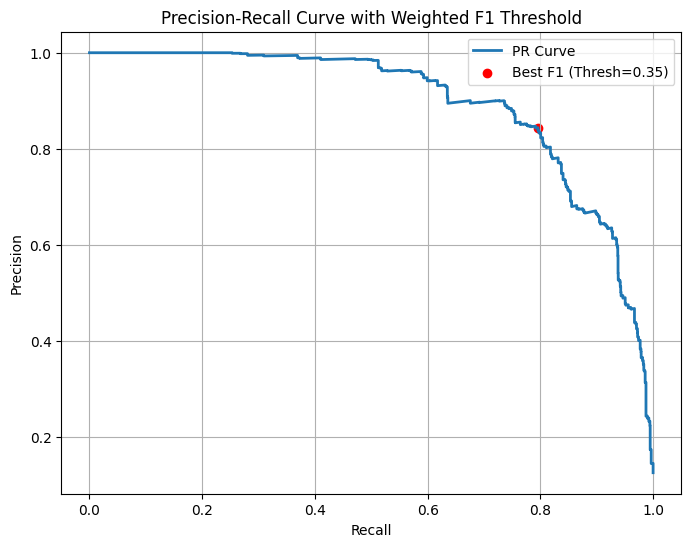

Best threshold: 0.35
F1 at best threshold: 0.819


In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np

# Get predicted probabilities for class 1 (FS=1)
y_proba = model.predict_proba(X_test)[:, 1]

# Compute precision-recall using sample weights
precision, recall, thresholds = precision_recall_curve(
    y_test, y_proba, sample_weight=weight_test
)

# Compute F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="PR Curve", lw=2)
plt.scatter(recall[best_idx], precision[best_idx], color="red", label=f"Best F1 (Thresh={best_threshold:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Weighted F1 Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Print best threshold and F1 score
print(f"Best threshold: {best_threshold:.2f}")
print(f"F1 at best threshold: {f1_scores[best_idx]:.3f}")

In [83]:
y_pred_custom = (y_proba >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_custom, sample_weight=weight_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97  264866.0
           1       0.84      0.80      0.82   38363.0

    accuracy                           0.96  303229.0
   macro avg       0.91      0.89      0.90  303229.0
weighted avg       0.95      0.96      0.95  303229.0

